# Markov Chain Monte Carlo em Python

Tradução do artigo de Will Koehrsen _Markov Chain Monte Carlo in Python A Complete Real-World Implementation_, original netse [link](https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98)

Nos últimos meses, encontrei um termo repetidamente no mundo da ciência de dados: Markov Chain Monte Carlo.   

No meu laboratório de pesquisa, em podcasts, em artigos, toda vez que eu ouvia a frase eu acenava com a cabeça e achava que soava muito legal, com apenas uma vaga ideia do que alguém estava falando.   

Várias vezes tentei aprender MCMC e inferência bayesiana, mas sempre que comecei a ler os livros, logo desisti. Exasperado, busquei o melhor método para aprender qualquer nova habilidade: aplicá-la a um problema.  

Usando alguns dos meus dados de sono que pretendia explorar e um livro prático baseado em aplicativos (Métodos Bayesianos para Hackers, disponível gratuitamente [online](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)), finalmente aprendi a Cadeia de Markov Monte Carlo por meio de um projeto do mundo real.   

Como de costume, foi muito mais fácil (e mais agradável) entender os conceitos técnicos quando os apliquei a um problema, em vez de lê-los como ideias abstratas em uma página.   

Este artigo percorre a implementação introdutória do Markov Chain Monte Carlo em Python que finalmente me ensinou essa poderosa ferramenta de modelagem e análise.

# Descrição do Problema

![image](https://miro.medium.com/max/398/1*_V59tsiXl9HrqmJ4z7oTxQ.png)

Meu relógio Garmin Vivosmart monitora a hora em que adormeço e acordo todos os dias usando sensor de movimento e monitoramento de frequência cardíaca. Para aumentar esses dados, estimei a probabilidade de estar dormindo com base na condição da luz do meu quarto (ligada / desligada) e se meu telefone está carregando (sim / não). Meu objetivo é usar esses dados para criar um modelo que retorne a probabilidade de estar dormindo em um determinado momento. O objetivo final pode ser expresso matematicamente como:

$$P(\text{sono} | \text{tempo})$$.

Em termos da teoria da probabilidade, essa é a probabilidade posterior de que estou dormindo, dado o tempo ou o horário.

# Exploração de dados de vigília e sono

Os dados de vigília e sono contêm mais de dois meses de informações.  

O relógio Garmin registra quando eu adormeço e acordo com base no movimento e na frequência cardíaca.  

Não é 100% preciso, pois muitas vezes pensará que estou dormindo se desligar as notificações e ler tranquilamente na cama. 

Às vezes, temos que lidar com dados imperfeitos e, como há observações mais verdadeiras do que falsas, podemos esperar que os dados corretos tenham um efeito maior no modelo.

Primeiro, importaremos as bibliotecas necessárias e visualizaremos os dados de sono e de vigília.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib



# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [2]:
plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

In [3]:
# Data formatted in different notebook
sleep_data = pd.read_csv('data/sleep_data.csv')
wake_data = pd.read_csv('data/wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

## Dados de adormecimento

Cada ponto representa uma observação em um momento específico com a intensidade da cor correspondendo ao número de pontos naquele momento. Podemos ver que tenho tendência a adormecer um pouco depois das 22:00.

In [4]:
print('Número de observações do sono %d' % len(sleep_data))

Número de observações do sono 11340


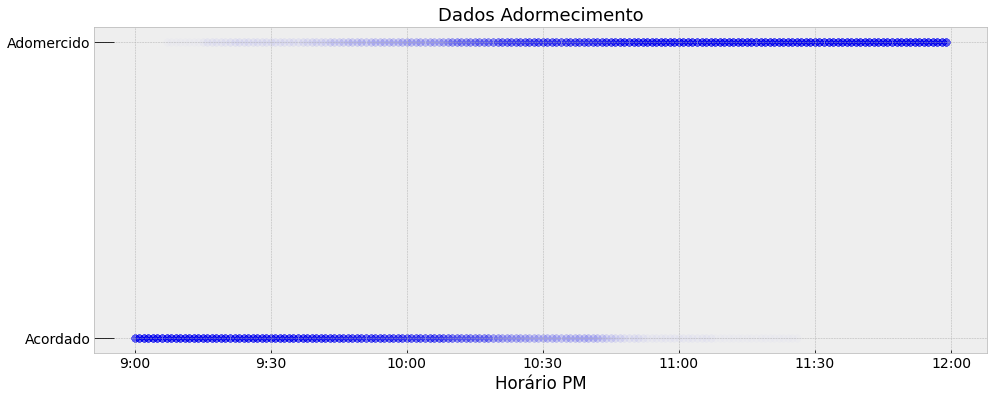

In [5]:
figsize(16, 6)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Acordado', 'Adomercido']); plt.xlabel('Horário PM'); 
plt.title('Dados Adormecimento', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

## Dados de Despertar

Meu alarme está definido para 6h, todos os dias da semana, e os dados de despertar são mais consistentes do que os dados de sono. Quase sempre acordo dentro de uma janela de 10 minutos, por volta das 6h.

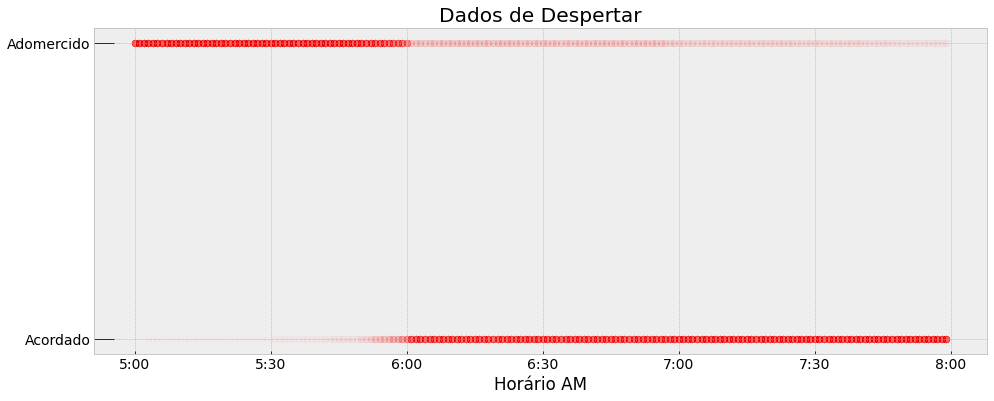

In [6]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Acordado', 'Adomercido']); plt.xlabel('Horário AM');
plt.title('Dados de Despertar')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

# Função Logística para Representar a Transição

Precisamos decidir sobre uma função para representar a transição de estar acordado para dormir. Existem vários modelos aceitáveis e, aqui, assumiremos que essa transição pode ser modelada como uma função logística. Uma função logística (também chamada de sigmóide) é uma função não linear limitada entre 0 e 1. Como ${t \to -\infty}, {p(s|t) \to 0}$ e, com ${t \to +\infty}, {p(s|t) \to 1}$. A expressão para uma distribuição de probabilidade logística para o sono em função do tempo é:

$$p(s|t) = \frac{1}{ 1 + e^{\;\beta t } }$$

O parâmetro $\beta$ é desconhecido e pode ser estimado usando a amostragem Markov Chain Monte Carlo. Amostras MCMC anteriores para cada parâmetro, tentando maximizar a probabilidade do parâmetro dado os dados. 

Várias funções logísticas com vários parâmetros $\beta$ são mostradas abaixo:

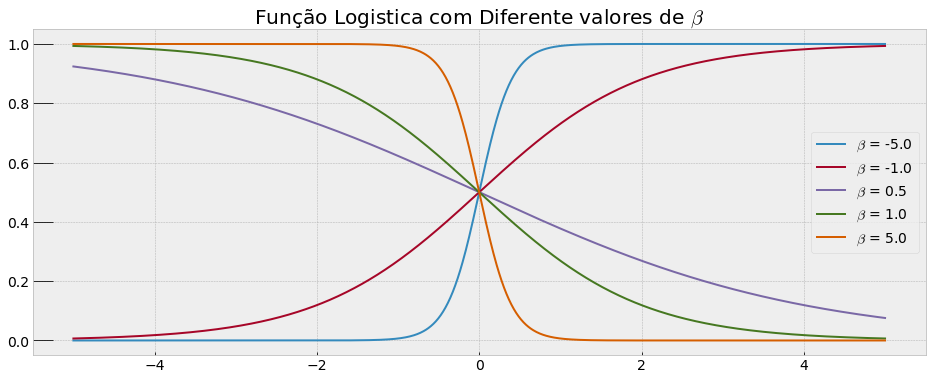

In [7]:
figsize(16, 6)

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Função Logistica com Diferente valores de $\beta$');

Há um problema com a função logística básica, conforme mostrado acima: a transição é centrada em 0. No entanto, em meus dados de sono, a transição é por volta das 22h para dormir e 6h para acordar. Abordamos isso adicionando um deslocamento, chamado de viés, para ajustar a localização da função logística. A função logística agora é:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$

Isso introduz outro parâmetro desconhecido, $ \ alpha $, que também encontraremos em Markov Chain Monte Carlo.

A função logística com vários parâmetros $ \ alpha $ e $ \ beta $ é mostrada abaixo.

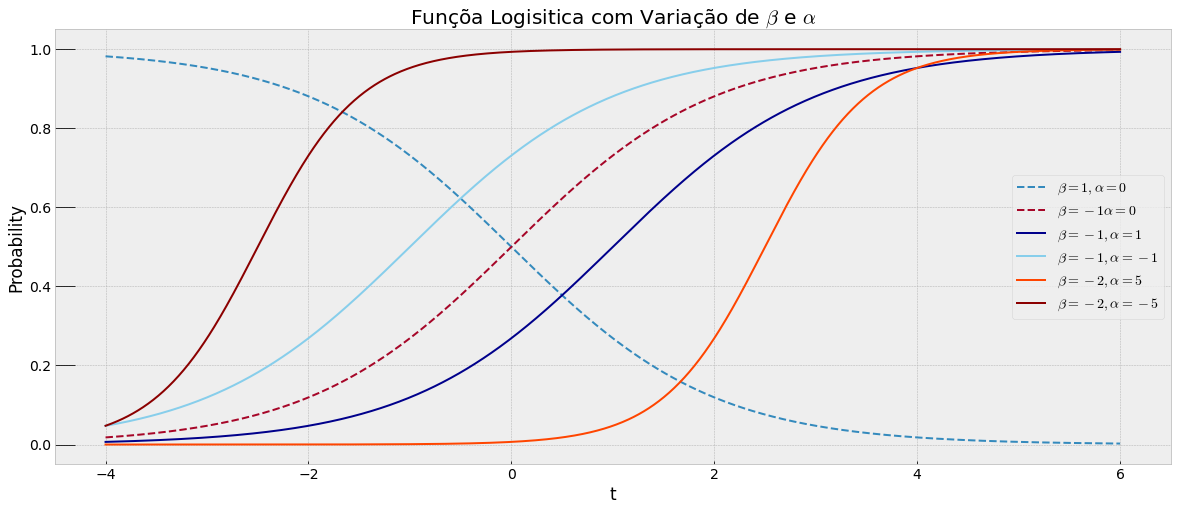

In [9]:
figsize(20, 8)

# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 6, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1, \alpha = 0$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1 \alpha = 0$", ls="--", lw=2)

plt.plot(x, logistic(x, -1, 1), 
         label=r"$\beta = -1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, -1, -1),
         label=r"$\beta = -1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -2, 5), 
         label=r"$\beta = -2, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -2, -5), 
         label=r"$\beta = -2, \alpha = -5$", color="darkred")
plt.legend(); plt.ylabel('Probability'); plt.xlabel('t')
plt.title(r'Funçõa Logisitica com Variação de $\beta$ e $\alpha$');

$\beta$ muda a direção e inclinação da curva, enquanto $\alpha$ muda a localização. Usaremos MCMC para encontrar o valor mais provável desses parâmetros nos dados.

## Distribuiçõa a Priori $\beta$ e $\alpha$

Não temos evidências que sugiram quais são as distribuições anteriores para os parâmetros do modelo $\beta$ e $\alpha$. Portanto, podemos modelá-los como se viessem de uma distribuição normal. A distribuição normal, ou gaussiana, é definida pela média, $\mu$, e pela precisão, $\tau$.  

A precisão é o recíproco do desvio padrão, $\sigma$. 

A média define a localização da distribuição e a precisão mostra a dispersão. 

Um valor maior de $\tau$ indica que os dados estão menos espalhados (são mais precisos) e, portanto, a variação é menor. 

A média pode ser positiva ou negativa, mas a precisão sempre será positiva. Uma distribuição normal conforme definida aqui é representada como:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

As funções de densidade de probabilidade para três distribuições normais são mostradas abaixo.

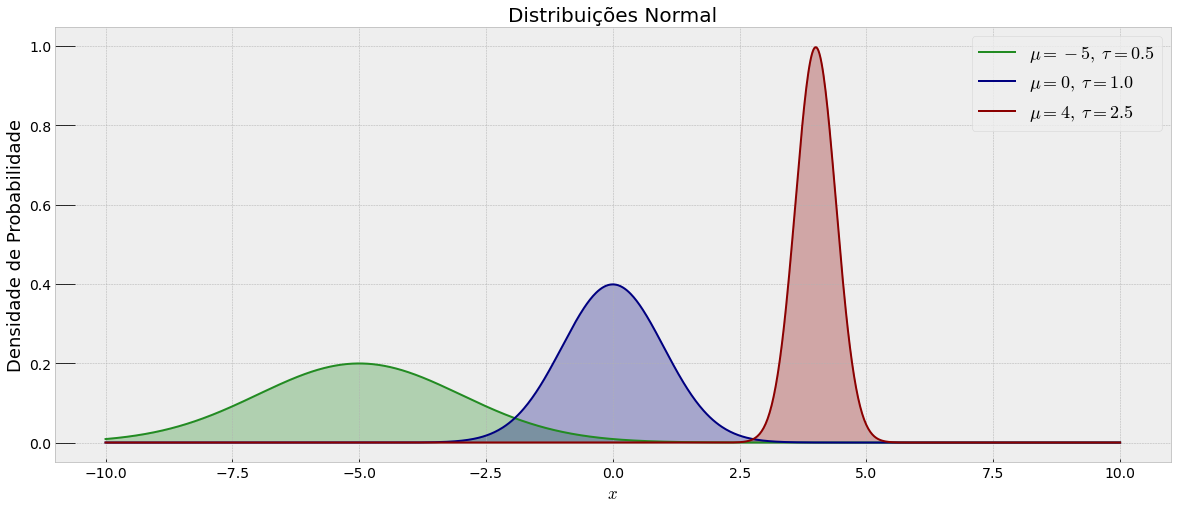

In [10]:
figsize(20, 8)
# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1 / param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("Densidade de Probabilidade", size = 18)
plt.title("Distribuições Normal", size = 20);

## Espaço de Busca de Parâmetros

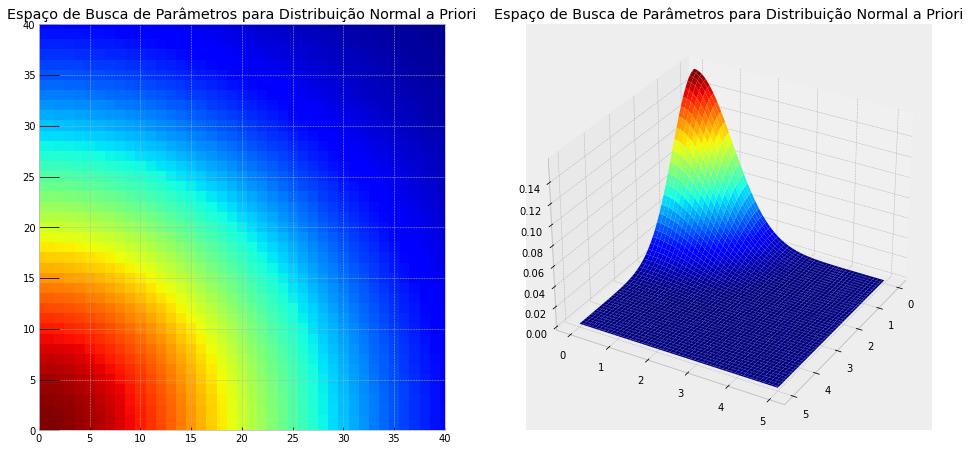

In [11]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Espaço de Busca de Parâmetros para Distribuição Normal a Priori")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("Espaço de Busca de Parâmetros para Distribuição Normal a Priori");

O valor esperado de uma distribuição normal é a média.
$$ E[ X | \mu, \tau] = \mu$$ 

A variância de uma distribuição normal é igual a:

$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$

Novamente, não temos suposições sobre o valor de $\mu$ ou $\tau$ nas distribuições anteriores de $\alpha$ e $\beta$.  

Quando inicializamos o modelo, podemos usar $\mu = 0$ e uma variação relativamente grande, como $\tau = 0,05$.   

A Cadeia de Markov Monte Carlo irá amostrar valores de $\mu$ e $\tau$ que tentam maximizar a probabilidade de $\alpha$ e $\beta$ sob os dados.

## Markov Chain Monte Carlo

A Cadeia de Markov Monte Carlo irá amostrar $\beta$ e $\alpha$ de duas distribuições normais para encontrar os parâmetros. A cada iteração (estado), uma estimativa para $\beta$ e $\alpha$ é extraída do anterior.  

Se os parâmetros aumentarem a probabilidade dos dados, o estado é aceito, mas se os parâmetros não estiverem de acordo com os dados, o estado é rejeitado.   

Monte Carlo refere-se à parte de amostragem do algoritmo. 

Cadeia de Markov significa que o próximo estado depende apenas do estado atual em um processo de primeira ordem (a segunda ordem depende da etapa atual e 1 etapa anterior, terceira ordem da etapa atual e 2 etapas anteriores e assim por diante). MCMC retornará cada amostra dos parâmetros para o número de etapas especificadas. 

Isso é conhecido como rastreamento de modelo.  

Para encontrar os parâmetros mais prováveis, podemos obter a média das amostras no rastreamento. 

MCMC não dá uma resposta exata, mas tenta encontrar os estados de máxima verossimilhança sob os dados.



Ao modelar com MCMC, até 50% das etapas iniciais, conhecidas como parte de burn-in do traço, são descartadas porque o algoritmo retorna parâmetros mais prováveis conforme o número de amostras aumenta. As amostras iniciais são menos prováveis ​​do que as últimas amostras, em média. 

Existem vários métodos para testar a convergência do MCMC, incluindo a inspeção visual do traço e o cálculo da autocorrelação do traço (uma autocorrelação inferior é um indicador de convergência).  

Examinaremos o traço neste exemplo, mas não tomaremos medidas rigorosas para tratar da convergência. Existem também vários métodos para escolher um valor inicial inteligente para a Cadeia de Markov, como a estimativa de A Posterior Máxima. A escolha de um valor inicial inteligente pode acelerar a convergência.

# Posterior Probability of Sleep given Time

Temos todas as peças para a probabilidade poesterior e agora podemos juntá-las. A função logística descreve a transição de acordado para adormecido, mas não conhecemos os parâmetros $ \beta$ e $\alpha$. 
O objetivo é encontrar os parâmetros da função logística que maximizam a probabilidade dos dados observados. Os parâmetros são assumidos como vindo de uma distribuição normal definida por uma média $\mu$ e uma variância $\tau$. 
O algoritmo MCMC irá amostrar valores de $\mu$ e $\tau$ para $\alpha$ e $\beta$ para tentar maximizar os parâmetros da função logística dados os dados.

Os dados são conectados aos parâmetros por meio de uma variável de Bernoulli.

## Bernoulli Variable

Uma variável bernoulli é uma variável aleatória discreta que é 0 ou 1. 

Em nosso exemplo, podemos modelar adormecido ou acordado como uma variável Bernoulli onde acordado é 0 e adormecido é 1. 

A variável Bernoulli para sono depende do tempo, em um forma definida pela função logística.

$$ \text{ Probabilidade Sono, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

$p(t_i)$ é a função logística com a variável independente tempo, então isso se torna: 

$$ P(\text{sono} | t_i) = \text{Ber}(\frac{1}{1 + e^{(\beta t_i + \alpha)}})$$

O objetivo do MCMC é encontrar os parâmetros $\alpha$ e $\beta$ usando os dados e assumindo antecedentes normais.

### Modelo PyMC3

Estamos usando uma poderosa biblioteca de inferência bayesiana em Python chamada PyMC3. Esta biblioteca possui recursos para executar Markov Chain Monte Carlo e outros algoritmos de inferência. Este relatório não detalha o PyMC3, mas um ótimo livro para começar é _Probabilistic Programming and Bayesian Methods for Hackers_ de Cameron Davidson-Pilon, que está disponível gratuitamente em [GitHub](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

O código a seguir cria o modelo e executa MCMC, usando `N_SAMPLES` number of samples for $\beta$ and $\alpha$. The specific sampling algorithm is [Metropolic Hastings](http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf). 

Nós alimentamos os dados e dizemos ao modelo que são observações da variável de Bernoulli. O modelo então tenta maximizar os parâmetros sob os dados.

In [12]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [13]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 85 seconds.
The number of effective samples is smaller than 10% for some parameters.


A variável `trace` contém todas as amostras retiradas da posterior para 𝛽 e 𝛼. 

Podemos representar graficamente essas amostras para explorar como elas mudam no decorrer da amostragem. 

A ideia do MCMC é que as amostras se tornam mais prováveis dados os dados conforme o algoritmo continua. 

Em outras palavras, o algoritmo MCMC converge nos valores mais prováveis conforme as amostras aumentam. 

Esperamos que os últimos valores extraídos da parte posterior sejam mais precisos do que os valores anteriores. 

Na Cadeia de Markov Monte Carlo, é prática comum descartar uma parte das amostras, geralmente cerca de 50%, que são conhecidas como amostras de burn-in. 

Para este relatório, não estou descartando nenhuma amostra, mas em um aplicativo real, executaríamos o modelo por muito mais etapas e descartaria as amostras iniciais.

## Visualize os posteriores para $\beta$ e $\alpha$

Os valores retornados no `trace` são todas as amostras desenhadas para os parâmetros. Podemos inspecionar visualmente esses valores em histogramas.

In [14]:
# Extract the alpha and beta samples
alpha_samples = sleep_trace["alpha"][5000:, None]
beta_samples = sleep_trace["beta"][5000:, None]

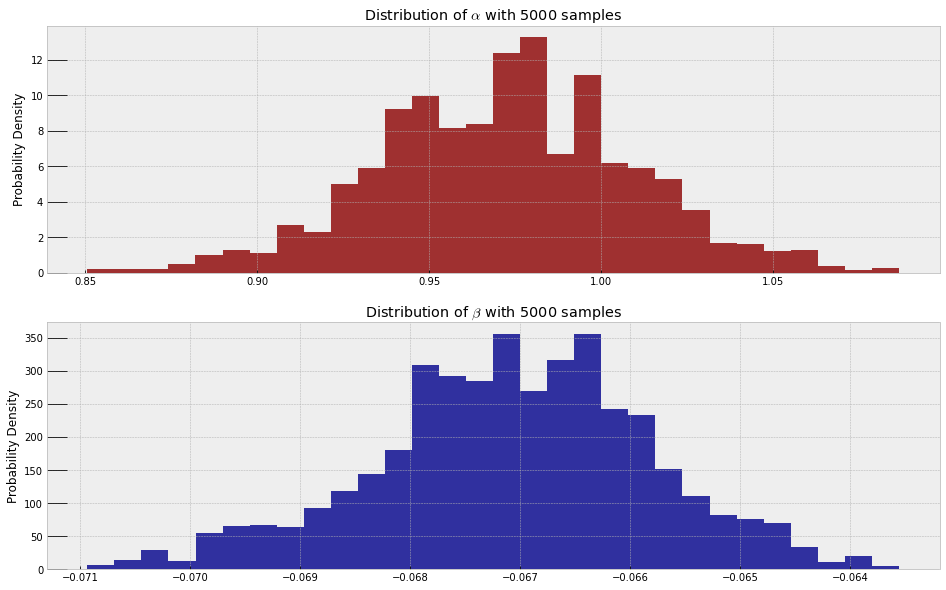

In [15]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');


Se os valores de 𝛽 estivessem centrados em torno de 0, isso indicaria que o tempo não tem efeito na probabilidade de estar dormindo.

Os valores de 𝛼 também não estão em 0, indicando que há um deslocamento a partir das 22h em termos de estar dormindo.

Eu escolho representar os tempos como um deslocamento a partir das 22h para evitar lidar com os tempos de dados tanto quanto possível.

A disseminação dos dados nos dá uma medida de incerteza sobre os dados.

Um spread maior indica mais incerteza.

Como há uma sobreposição considerável nas observações para acordado e dormindo, espera-se que a incerteza seja grande.

Para encontrar a distribuição posterior mais provável para o sono de acordo com o tempo, tomamos a média das amostras 𝛼 e 𝛽.

## Posterior para Visualização de  Sono

In [16]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

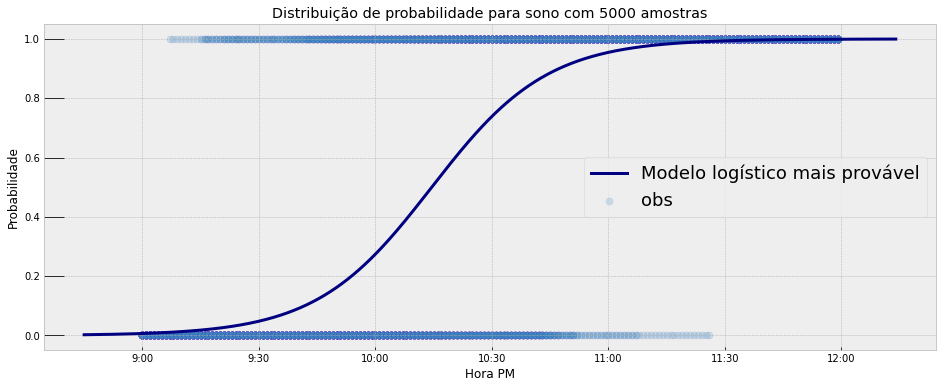

In [18]:
figsize(16, 6)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="Modelo logístico mais provável")
plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Distribuição de probabilidade para sono com% d amostras' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probabilidade')
plt.xlabel('Hora PM');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

A probabilidade posterior aumenta de 0 para 1 conforme o tempo passa. O modelo não é perfeito devido ao ruído nos dados, mas é uma aproximação adequada com base nas observações e pode fornecer estimativas úteis.

In [19]:
print('A probabilidade de dormir aumenta para mais de 50% às 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

A probabilidade de dormir aumenta para mais de 50% às 10:14 PM.


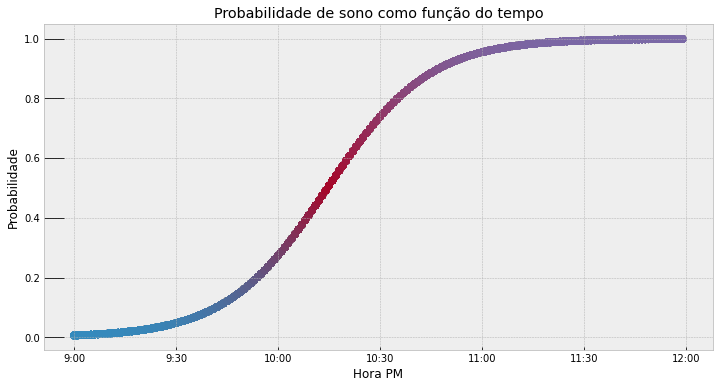

In [20]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probabilidade de sono como função do tempo')
plt.xlabel('Hora PM');
plt.ylabel('Probabilidade');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

O posterior pode ser consultado a qualquer momento (como um deslocamento a partir das 22h) para encontrar a probabilidade de eu estar dormindo.

In [21]:
print('10:00 PM Probabilidade de estar dormindo: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM Probabilidade de estar dormindo: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM Probabilidade de estar dormindo: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM Probabilidade de estar dormindo: 27.44%.
9:30  PM Probabilidade de estar dormindo: 4.81%.
10:30 PM Probabilidade de estar dormindo: 73.88%.


### Intervalo de confiança

Existem muitos outros diagnósticos do modelo que podemos realizar. Por exemplo, sabemos que há uma quantidade considerável de incerteza em nossas estimativas para $\alpha$ e $\beta$. Para refletir isso no gráfico, podemos incluir o intervalo de confiança de 95% a cada vez com base em todas as amostras.

In [22]:
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

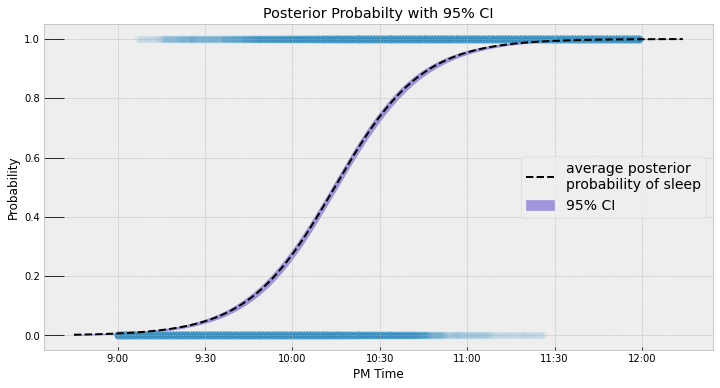

In [23]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); 
plt.title('Posterior Probabilty with 95% CI');

At each time, there is a measure of uncertainty as to whether or not I am asleep. This represents the fact that MCMC does not return the True parameters.

## Distribuição de probabilidade posterior para um tempo específico

Também podemos representar graficamente a distribuição posterior do sono de cada vez como um histograma com base em todas as amostras dos parâmetros. Isso nos dá uma outra visão da incerteza do modelo.

In [27]:
def sleep_posterior(time_offset, time):
    figsize(16, 8)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Distribuição de probabilidade para sono em %s PM' % time)
    plt.xlabel('Probabilidade de Sono'); plt.ylabel('Samples')
    plt.show();

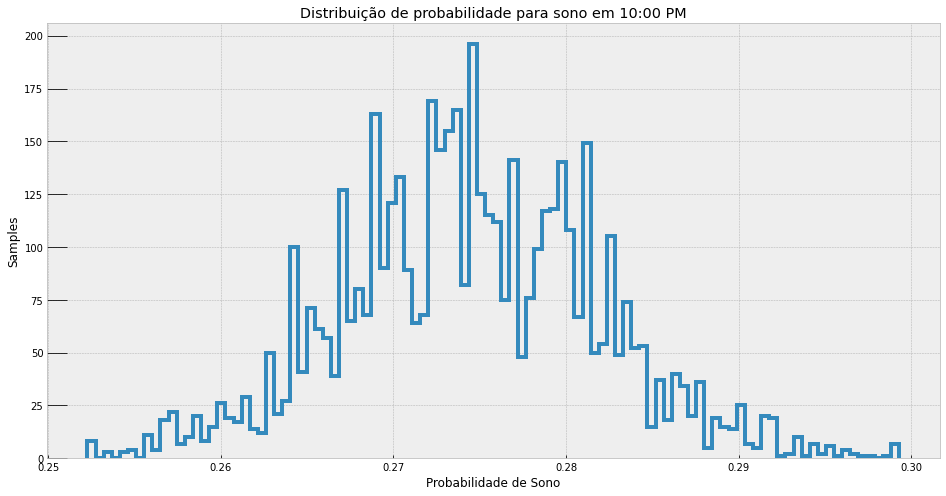

In [28]:
sleep_posterior(0, '10:00')

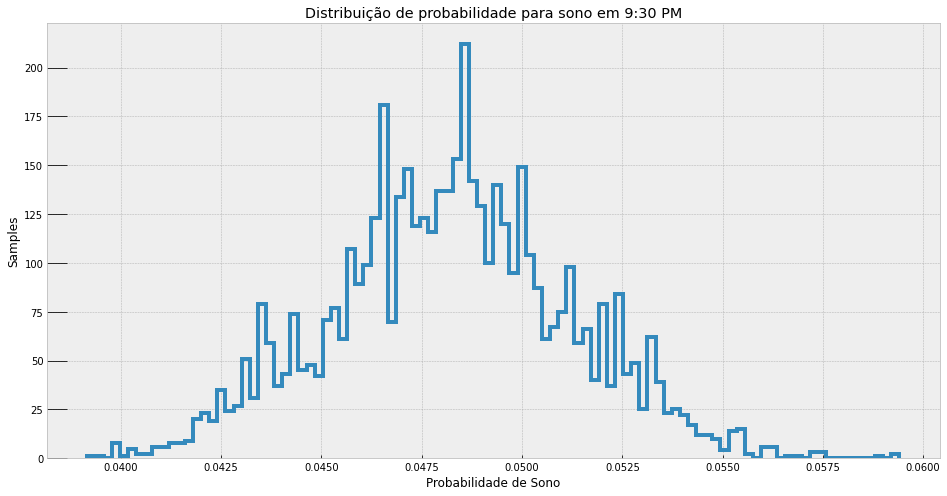

In [29]:
sleep_posterior(-30, '9:30')

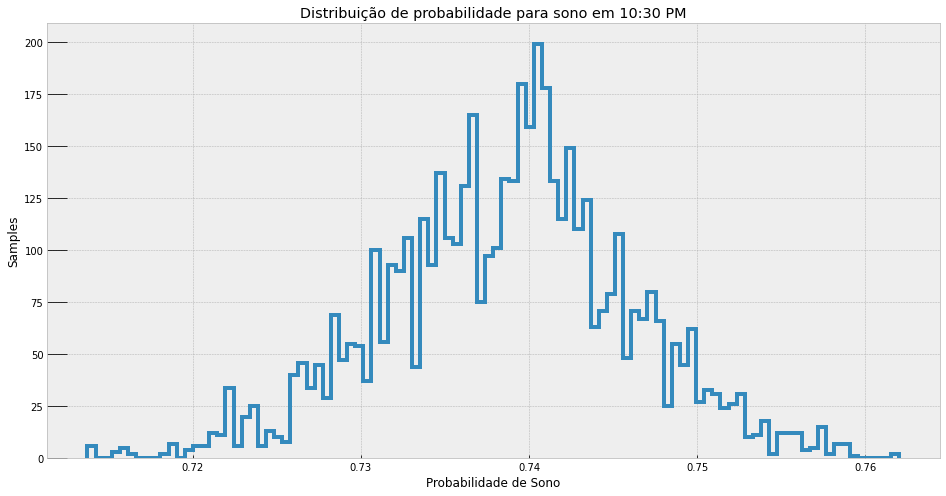

In [30]:
sleep_posterior(30, '10:30')

In [31]:
print('Most likely alpha parameter: {:.6f}.'.format(alpha_est))
print('Most likely beta  parameter: {:.6f}.'.format(beta_est))

Most likely alpha parameter: 0.972512.
Most likely beta  parameter: -0.067072.


## Convergência na Cadeia de Markov Monte Carlo

Como podemos saber se o modelo convergiu? Podemos observar o traço ou o caminho dos valores durante a amostragem. 

Outra opção é examinar a autocorrelação das amostras. 

Na modelagem da Cadeia de Markov, as amostras são correlacionadas com elas mesmas porque o próximo valor depende do estado atual (ou o estado atual e os estados passados com base na ordem). 

Inicialmente, o algoritmo tende a vagar pelo espaço de busca e terá uma alta autocorrelação. Conforme o algoritmo converge, as amostras se estabelecerão em torno de um valor e uma medida de convergência é uma baixa autocorrelação. 

Não faremos um estudo rigoroso de convergência neste relatório, mas podemos traçar os traços de todas as amostras.


## Trace Plots

The plots below show all the samples of $\alpha$ and $\beta$ from the algorithm.

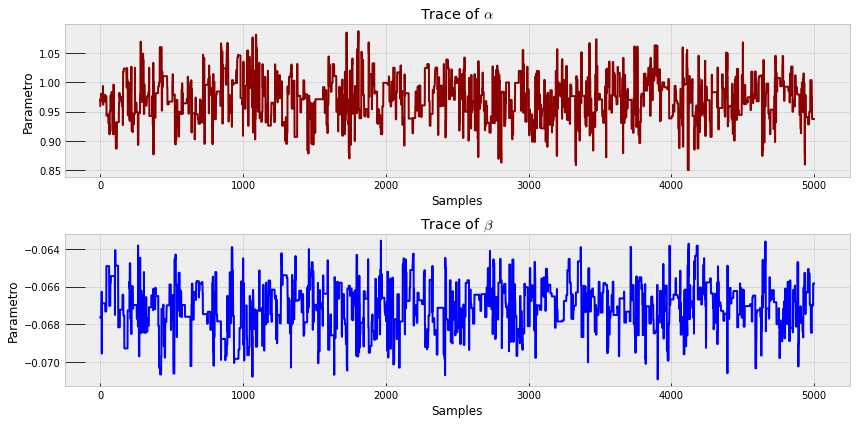

In [32]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parametro');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parametro');
plt.tight_layout(h_pad=0.8)


### Diagnóstico integrado

PyMC3 tem muitos diagnósticos integrados para avaliação de modelo. Aqui estão os gráficos de rastreamento e de autocorrelação. 

C:\Users\domin.DESKTOP-G0181GH\anaconda3\envs\Python36\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


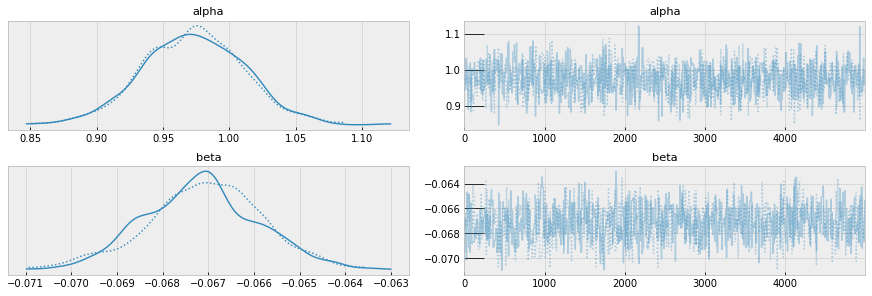

In [33]:
figsize(20, 12)
pm.traceplot(sleep_trace, ['alpha', 'beta']);

C:\Users\domin.DESKTOP-G0181GH\anaconda3\envs\Python36\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


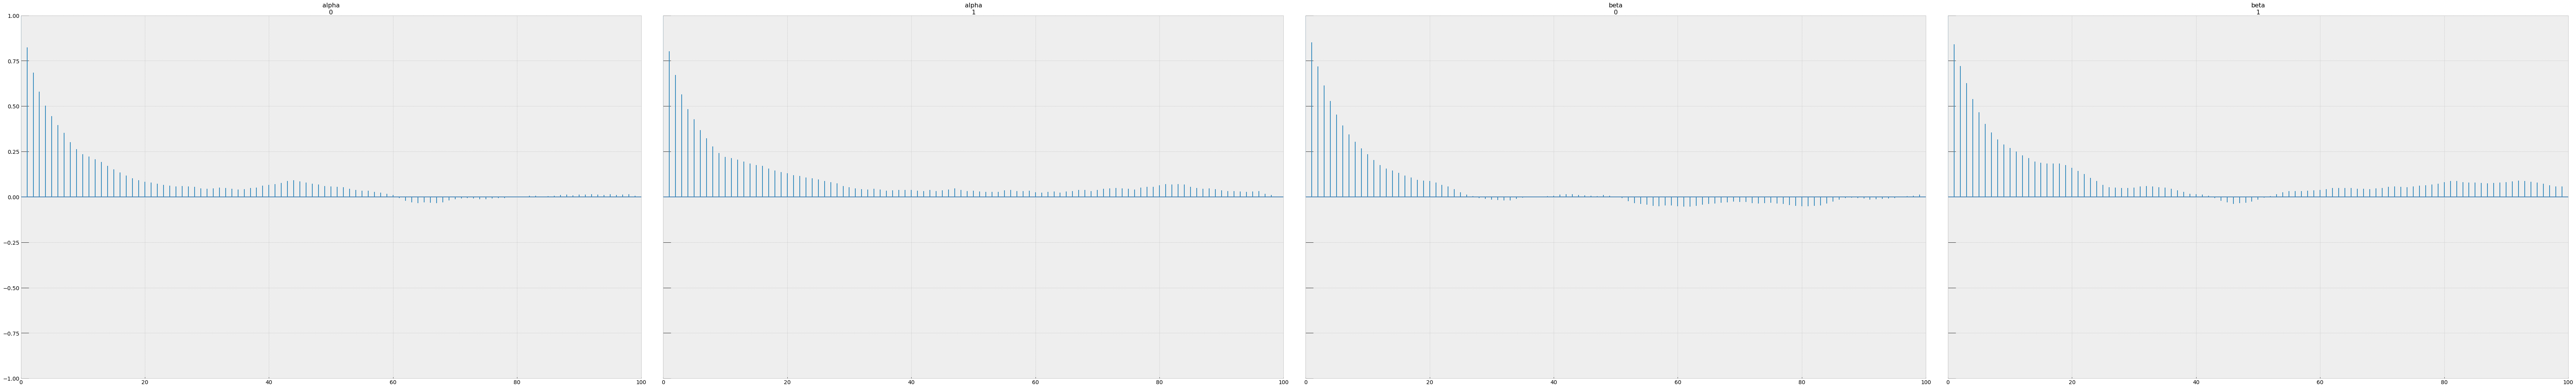

In [34]:
pm.autocorrplot(sleep_trace, ['alpha', 'beta']);

# Modelo Vigília (Wake)

Podemos repetir o mesmo procedimento para encontrar um modelo para os dados de vigília.

In [36]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 86 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Visualize Posterior para Wake dada hora

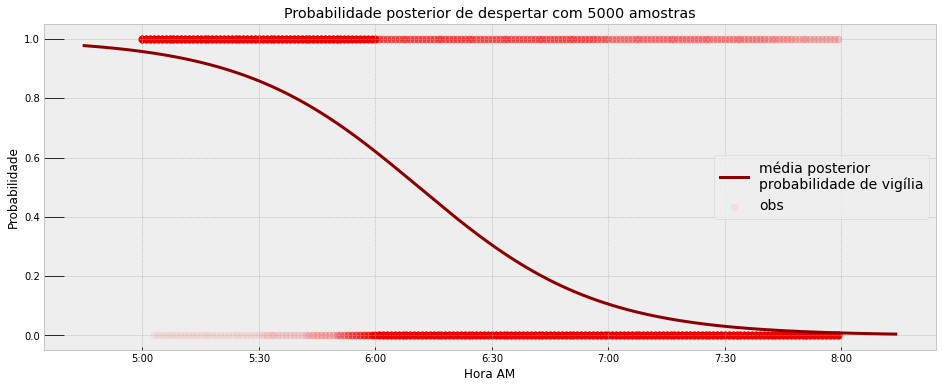

In [39]:
# Extract the alpha and beta samples
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(16, 6)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="média posterior \nprobabilidade de vigília")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Probabilidade posterior de despertar com %d amostras' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probabilidade')
plt.xlabel('Hora AM');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

O modelo não tem uma transição acentuada, que é o que eu esperava porque tenho tendência a acordar por volta das 6h. Várias vezes, quando acordei várias horas depois, mudou a curva para a direita.

In [40]:
print('A probabilidade de estar acordado passa de 50% em 6:{} AM.'.format(int(time_est[np.where(wake_est < 0.5)][0])))

A probabilidade de estar acordado passa de 50% em 6:11 AM.


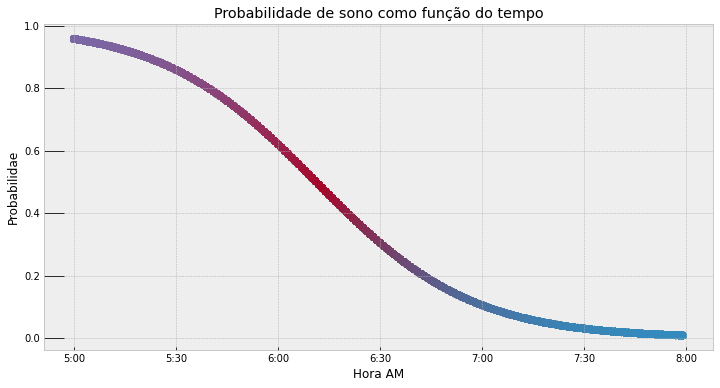

In [41]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = wake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probabilidade de sono como função do tempo')
plt.xlabel('Hora AM');
plt.ylabel('Probabilidae');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

## Investigue o modelo Wake

In [42]:
print('Probabilidade de estar acordado em 5:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est))))
print('Probabilidade de estar acordado em 6:00 AM: {:.2f}%.'.
      format(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est))))
print('Probabilidade de estar acordado em 6:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est))))

Probabilidade de estar acordado em 5:30 AM: 14.14%.
Probabilidade de estar acordado em 6:00 AM: 37.97%.
Probabilidade de estar acordado em 6:30 AM: 69.47%.


# Modelo para duração do sono

Também podemos formar um modelo para estimar o período de tempo mais provável em que durmo. Podemos primeiro olhar para os dados e então determinar qual função se ajusta à distribuição de probabilidade.

In [43]:
raw_data = pd.read_csv('data/sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

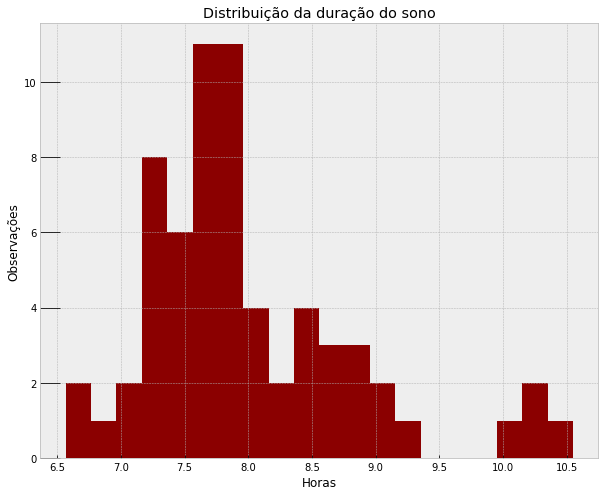

In [44]:
figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('Horas'); plt.title('Distribuição da duração do sono'); 
plt.ylabel('Observações');

A distribuição está inclinada para a direita. Portanto, podemos usar uma distribuição enviesada para modelar a duração do sono.

Também podemos querer usar uma distribuição bimodal porque parece haver dois modos.

Por enquanto, vou me limitar a representar a duração da distribuição do sono como uma normal distorcida. Uma distribuição normal distorcida é mostrada abaixo.

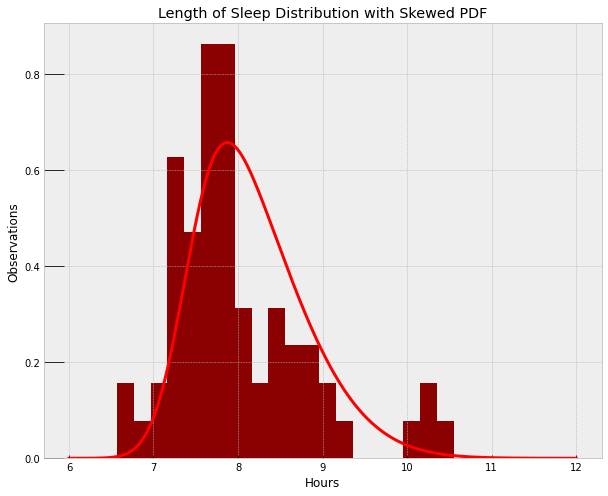

In [48]:
a = 3
fig, ax = plt.subplots(1, 1)
x = np.linspace(6, 12, 1000)


figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred', density=True)
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution with Skewed PDF'); 
plt.ylabel('Observations');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', 
         lw=3, label='skewnorm pdf');

In [49]:
with pm.Model() as duration_model:
    # Three parameters to sample
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration is a deterministic variable
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, 
                              sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings for sampling
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)
    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [alpha_skew]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [50]:
# Extract the most likely estimates from the sampling
alpha_skew_samples = duration_trace['alpha_skew'][5000:]
mu_samples = duration_trace['mu'][5000:]
tau_samples = duration_trace['tau'][5000:]

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

## Visualize a distribuição posterior para a duração do sono

A duração mais provável do sono é 7.65 hours.


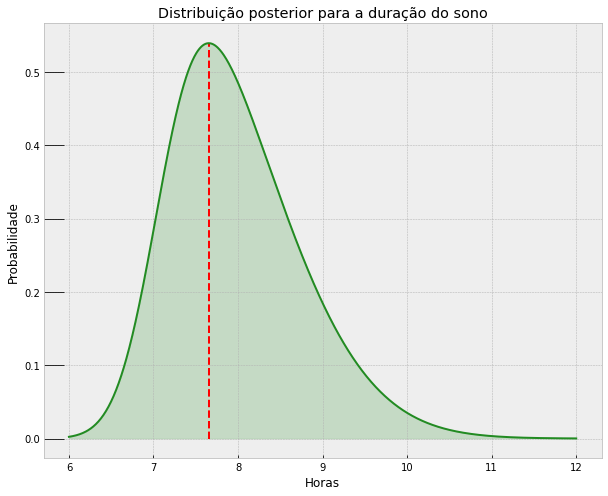

In [52]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('Horas'); plt.ylabel('Probabilidade'); 
plt.title('Distribuição posterior para a duração do sono');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='red', 
           label = 'Duração Mais Provável');

print('A duração mais provável do sono é {:.2f} hours.'.format(x[np.argmax(y)]))

### Consultar o modelo posterior

In [53]:
print('Probabilidade de pelo menos 6,5 horas de sono = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probabilidade de pelo menos 8,0 horas de sono = = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probabilidade de pelo menos 9,0 horas de sono = = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

Probabilidade de pelo menos 6,5 horas de sono = 99.10%.
Probabilidade de pelo menos 8,0 horas de sono = = 44.19%.
Probabilidade de pelo menos 9,0 horas de sono = = 11.06%.


## Visualize o posterior e os dados

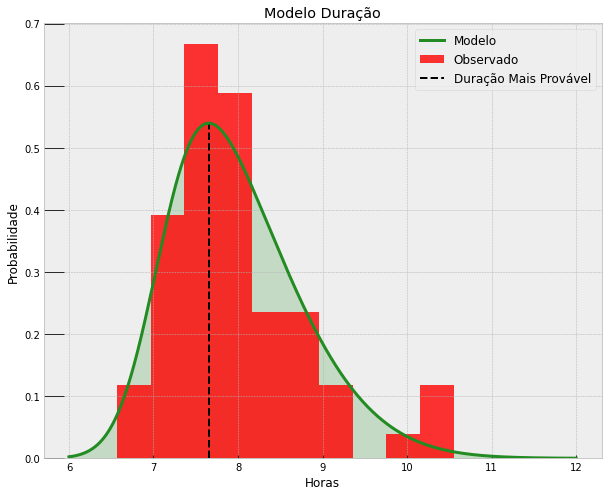

In [55]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
figsize(10, 8)
# Plot the posterior distribution
plt.plot(x, y, color = 'forestgreen', 
         label = 'Modelo', lw = 3)
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);

# Plot the observed values
plt.hist(duration, bins=10, color = 'red', alpha=0.8,
         label='Observado', density=True)
plt.xlabel('Horas'); plt.ylabel('Probabilidade'); 
plt.title('Modelo Duração');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='k', 
           label = 'Duração Mais Provável');
plt.legend(prop={'size':12});

A distribuição normal distorcida posterior parece ajustar-se bem aos dados.

No entanto, os dados podem ser melhor modelados como duas distribuições separadas, dado o segundo modo à direita.

  O segundo modo não é capturado em uma única distribuição normal enviesada.

No geral, esse modelo ainda fornece uma estimativa razoável para a probabilidade de duração do meu sono.

# Conclusões

Com base nas observações, podemos afirmar o seguinte:

* __Em média, adormeço por volta das 22h14__
* __Em média, acordo às 6h11__
* __Minha duração média do sono é de 7,67 horas__
    
Os modelos já me forneceram conhecimento sobre meus padrões de sono, e mais dados só melhorariam a aplicabilidade.

Eu poderia incorporar informações adicionais, como o dia da semana ou atividades diárias, para ver como elas afetam meu sono e, em seguida, fazer os ajustes necessários.

Embora este relatório tenha feito várias suposições e não tenha investigado completamente os modelos, foi um ótimo começo para analisar dados reais com métodos bayesianos.

Projetos, especialmente com aplicativos reais, são a melhor maneira de aprender, e estou ansioso para aplicar métodos bayesianos a problemas adicionais! 